In [1]:
import numpy as np
import pandas as pd
from scipy import stats

In [72]:
np.random.seed(2018)
X_MEAN = 20
X_STD_ERROR = 3
BETA_0 = 2
BETA_1 = -2.5

ERROR_FACTORY = {
    'normal': lambda size: stats.norm.rvs(0, 2, size=size),
    'uniform': lambda size: stats.uniform.rvs(-2, 4, size=size),
    'skew_normal': lambda size: stats.skewnorm.rvs(
        5, -5/np.sqrt(1 + 5**2)*np.sqrt(2/np.pi), 1, size=size),
    't': lambda size: stats.t.rvs(3/2, 0, 1, size=size),
    'rademacher': lambda size: 2*stats.bernoulli.rvs(0.5, size=size) - 1,
}

In [73]:
experiments = pd.DataFrame(index=pd.MultiIndex.from_product([
    pd.Series([15, 30], dtype=np.int32),
    pd.Series(['normal','uniform', 'skew_normal', 't'], dtype=np.object),
], names=['n', 'error_type'])).reset_index()
experiments

,n,error_type
0,15,normal
1,15,uniform
2,15,skew_normal
3,15,t
4,30,normal
5,30,uniform
6,30,skew_normal
7,30,t


In [74]:
from collections import OrderedDict

from stat570.linear_model.linear_regression import LinearRegression

def simulate(n, error_factory, num_trials, confidence_level=0.95, seed=2018):
    np.random.seed(seed)    
    X = stats.norm.rvs(X_MEAN, X_STD_ERROR, size=(n, 1))
    
    def simulate_trial():
        errors = error_factory(n)
        y = BETA_0 + np.squeeze(X*BETA_1) + errors
        linear_model = LinearRegression().fit(X, y)
        
        coefficients = linear_model.coefficients_
        
        return OrderedDict([
            ('beta_0_estimate', coefficients['estimate'][0]),
            ('beta_0_variance', np.square(coefficients['std_error'][0])),
            ('beta_1_estimate', coefficients['estimate'][1]),
            ('beta_1_variance', coefficients['std_error'][1]),
        ])
    return pd.DataFrame([simulate_trial() for _ in range(num_trials)])
    #trial_results = pd.DataFrame([simulate_trial() for _ in range(num_trials)])    
    #t_conf = stats.t.isf((1 - confidence_level)/2, df=n-2)

    #beta_0_error = trial_results['beta_0_estimate'] - BETA_0
    #beta_0_pct_conf_interval = np.sum(
    #    np.abs(beta_0_error) <= t_conf*np.sqrt(trial_results['beta_0_variance']))/num_trials
    #print(beta_0_pct_conf_interval)
    #print(np.var(trial_results['beta_0_estimate'] ,ddof=1))
        
    

In [75]:
trial_results = []
for _, experiment in experiments.iterrows():
    trial_results.append(simulate(experiment['n'], ERROR_FACTORY[experiment['error_type']], 1024))

In [87]:
def summarize_result(experiment, result):
    return OrderedDict([
        ('$n$', experiment['n']),
        ('Error Distribution', experiment['error_type']),
        ('$\\hat{\\beta}_0$', result['beta_0_estimate'].mean()),
        ('$\\hat{\\beta}_1$', result['beta_1_estimate'].mean()),
    ])

summaries = []
for (idx, experiment), trial_result in zip(experiments.iterrows(), trial_results):
    summaries.append(summarize_result(experiment, trial_result))
    
summaries = pd.DataFrame(summaries)
summaries

,$n$,Error Distribution,$\hat{\beta}_0$,$\hat{\beta}_1$
0,15,normal,2.128448,-2.506333
1,15,uniform,2.102775,-2.504675
2,15,skew_normal,2.022331,-2.501127
3,15,t,1.706663,-2.490891
4,30,normal,2.066954,-2.504255
5,30,uniform,2.003280,-2.500345
6,30,skew_normal,2.021427,-2.500797
7,30,t,1.992416,-2.501292


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


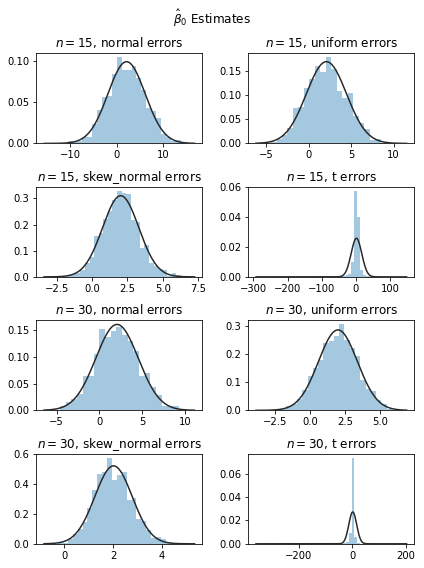

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(
    figsize=(6, 8), nrows=len(experiments)//2, ncols=2)

for idx, trial_result in enumerate(trial_results):
    ax = axes[idx//2][idx % 2]
    experiment = experiments.loc[idx]
    sns.distplot(trial_result['beta_0_estimate'], fit=stats.norm,
                 kde=False, ax=ax, axlabel='')
    ax.set_title('$n = {}$, {} errors'.format(experiment['n'], experiment['error_type']))

fig.suptitle('$\\hat{\\beta}_0$ Estimates')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig('p1_beta_hat_0_distribution.pdf', bbox_inches='tight')

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


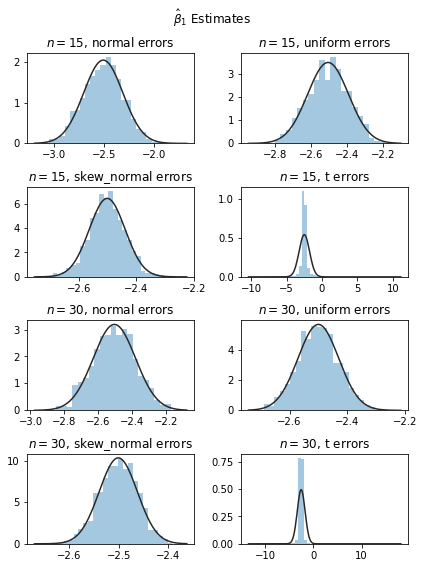

In [77]:
fig, axes = plt.subplots(
    figsize=(6, 8), nrows=len(experiments)//2, ncols=2)

for idx, trial_result in enumerate(trial_results):
    ax = axes[idx//2][idx % 2]
    experiment = experiments.loc[idx]
    sns.distplot(trial_result['beta_1_estimate'], fit=stats.norm,
                 kde=False, ax=ax, axlabel='')
    ax.set_title('$n = {}$, {} errors'.format(experiment['n'], experiment['error_type']))

fig.suptitle('$\\hat{\\beta}_1$ Estimates')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
#fig.savefig('p1_beta_hat_1_distribution.pdf', bbox_inches='tight')

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


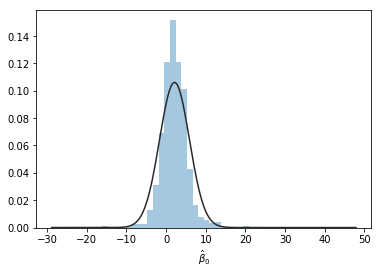

In [24]:
import seaborn as sns 

#trial_results['beta_0_estimate']
sns.distplot(trial_results['beta_0_estimate'], fit=stats.norm,
             kde=False, axlabel='$\\hat{\\beta}_0$');

In [607]:
np.mean(stats.t.rvs(1.1,0, 1, 15000000))

0.21114095706975328